# Implementation of the ER (Event Rejection) algorithm for four-jet signatures

In [1]:
from turtle import title
from h5py import File
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
#Opening the HDF5 File
input_file = "../user.maboelel.32438279._000005.output.h5"
#input_file = "../forked_TDD/run/EBdata_Output_Dump/output.h5"
data = File(input_file, 'r')
print("List of available datasets: " + str(list(data.keys())))

List of available datasets: ['jets', 'super_tracks', 'super_tracks_associated', 'super_tracks_fixed_cone']


In [3]:
#Accessing the 'Jets' Dataset
jets = data['jets']
print("The attributes of each element of the dataset (jets): " + str(jets.dtype.fields.keys()))
print("The shape of the dataset is: " + str(jets.shape))

The attributes of each element of the dataset (jets): dict_keys(['pt', 'HadronConeExclTruthLabelPt', 'n_tracks_nn', 'eta', 'fastDips_pb', 'fastDips_pc', 'fastDips_pu', 'dipz_z', 'dipz_negLogSigma2', 'HadronConeExclTruthLabelID', 'HadronConeExclExtendedTruthLabelID', 'jetPtRank', 'n_super_tracks', 'n_super_tracks_associated', 'n_super_tracks_fixed_cone', 'mcEventWeight', 'eventNumber', 'averageInteractionsPerCrossing', 'actualInteractionsPerCrossing', 'nPrimaryVertices', 'primaryVertexDetectorZ', 'primaryVertexDetectorZUncertainty'])
The shape of the dataset is: (165789,)


In [4]:
#Getting the events in our sample
uniques = np.unique(jets["eventNumber"])
print("The number of events in our sample is: " + str(len(uniques)))
print("The events_ID array looks like: " + str(uniques))

The number of events in our sample is: 39716
The events_ID array looks like: [3301001 3301002 3301003 ... 4872998 4872999 4873000]


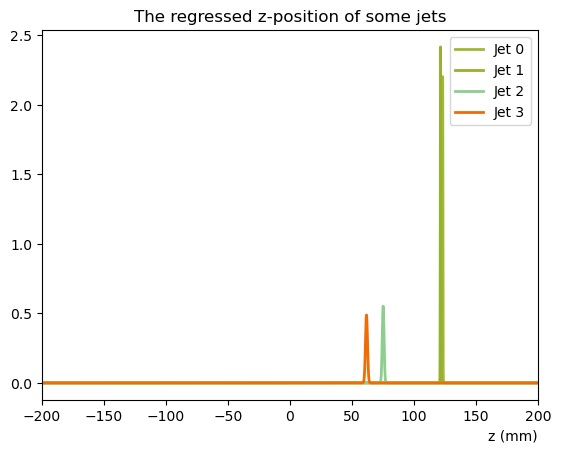

In [5]:
# Visualizing the jets in one event
event_id = uniques[3]
event_jets = jets[jets["eventNumber"] == event_id]
num_jets = len(event_jets)

import matplotlib.pyplot as plt
from scipy.stats import norm
import random
#Generating random colors for  the plot
color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
           for j in range(num_jets)]
ic = 0      #color counter
x = np.arange(-4*50, 4*50, 0.1)

for i in range(num_jets):
    #plt.plot(x, norm.pdf(x, event_jets[i]["dipz20230223_z"], np.exp(-0.5*event_jets[i]["dipz20230223_negLogSigma2"])), color=color[ic], linewidth=2, label='Jet '+str(ic))
    plt.plot(x, norm.pdf(x, event_jets[i]["dipz_z"]*50, np.exp(-0.5*event_jets[i]["dipz_negLogSigma2"])), color=color[ic], linewidth=2, label='Jet '+str(ic))
    ic = ic + 1    
plt.xlabel("z (mm)", loc='right')
plt.title('The regressed z-position of some jets')
plt.xlim([-4*50, 4*50])
plt.legend()
plt.show()
#plt.cla()

In [6]:
%%time

#Filtering the four-or-more jet events
fom_events = []
counter = 0

for id in uniques:
    if len(jets[jets["eventNumber"] == id]) >= 4:
        fom_events.append(id)
        counter +=1
    if counter == 10:
        break

CPU times: user 889 ms, sys: 0 ns, total: 889 ms
Wall time: 888 ms


In [7]:
%%time

import itertools as it

#list = jets[jets["eventNumber"] == fom_events[6]]

list = ['a', 'b', 'c', 'd', 'e']

combinations = []

for combination in it.combinations(list, 4):
    combinations.append(combination)
    
for comb in combinations:
    for jet in comb:
        print("hi")
        break
    break

print(combinations)

hi
[('a', 'b', 'c', 'd'), ('a', 'b', 'c', 'e'), ('a', 'b', 'd', 'e'), ('a', 'c', 'd', 'e'), ('b', 'c', 'd', 'e')]
CPU times: user 53 µs, sys: 0 ns, total: 53 µs
Wall time: 47.2 µs


In [8]:
# A function that takes in the event number and calculates the maximum over 4-jet combinations of log of the product of the 
# likelihood functions of all the jets in the event NUMERICALLY
import itertools as it

def get_max_log_likelihood_num(event_id):
    event_jets = jets[jets["eventNumber"] == event_id]
    #num_jets = len(event_jets)
    z = np.arange(-5*50, 5*50, 0.1)

    combinations = []
    mlpl_array = []

    for combination in it.combinations(event_jets, 4):
        combinations.append(combination)

    for comb in combinations:
        log_total_likelihood = -4 * np.log(np.sqrt(2*np.pi))
            
        for jet in comb:
            mu = jet["dipz_z"] * 50
            sigma = np.exp(-0.5*jet["dipz_negLogSigma2"]) *50
            #likelihood = (2*np.pi)**(-1/2) * (sigma)**(-1) * np.exp( -1 * (z - mu)**2 * (2 * sigma^2)**(-1) )
            log_total_likelihood -= ( np.log(sigma) + (z - mu)**2 * (2 * sigma**(2))**(-1) )
    
        mlpl_array.append(max(log_total_likelihood))
            
    
    max_log_likelihood = max(mlpl_array)
        
    return max_log_likelihood

In [9]:
# A function that takes in the event number and calculates the maximum over 4-jet combinations of log of the product of the 
# likelihood functions of all the jets in the event ANALYTICALLY

def get_max_log_likelihood_an(event_id):
    event_jets = jets[jets["eventNumber"] == event_id]
    #num_jets = len(event_jets)
    
    combinations = []
    mlpl_array = []

    for combination in it.combinations(event_jets, 4):
        combinations.append(combination)

    for comb in combinations:
        num = 0
        denom = 0
        second_term = 0
        third_term = 0
        for jet in comb:
            mu = jet["dipz_z"] * 50
            sigma = np.exp(-0.5*jet["dipz_negLogSigma2"]) * 50

            num += (mu) / (sigma**2)
            denom += 1 / (sigma**2)
            second_term -= np.log(sigma)
        for jet in comb:
            mu = jet["dipz_z"] * 50
            sigma = np.exp(-0.5*jet["dipz_negLogSigma2"]) * 50

            third_term -= ((num / denom) - mu)**2 / (2*sigma**2) 

    
        mlpl_array.append(-4 * np.log(np.sqrt(2*np.pi)) + second_term + third_term )
            
    
    max_log_likelihood = max(mlpl_array)
        
    return max_log_likelihood

In [10]:
%%time
#get_max_log_likelihood_num(fom_events[1])
get_max_log_likelihood_an(fom_events[1])

CPU times: user 35 ms, sys: 0 ns, total: 35 ms
Wall time: 34.6 ms


-7.128376854233859

In [11]:
len(jets[jets["eventNumber"] == fom_events[1]])

9

In [14]:
import time

def get_max_log_likelihood_dist(name, num=999999999999999):
    start = time.time()
    data = File(name, 'r')
    jets = data['jets']
    uniques = np.unique(jets["eventNumber"])

    max_log_likelihood_list = []
    no_of_processed_events = num
    counter = 0

    for id in uniques:
        if len(jets[jets["eventNumber"] == id]) >= 4:
            max_log_likelihood_list.append(get_max_log_likelihood_an(id))
            counter +=1
        if counter == no_of_processed_events:
            break

    if counter != no_of_processed_events:
        print("The number of four or more jet events in the sample is less than the provided number, there all the sample was run over.")
    end = time.time()
    print("The time of execution of this function is :", (end-start) , "s")

    return max_log_likelihood_list

def plot_distribution(max_log_likelihood_list):
    plt.hist(max_log_likelihood_list)
    plt.yscale("log")
    plt.xlabel("mlpl", loc='right')
    plt.title('Distribution of the maximum Log of the total likelihood function per event')
    plt.show()

The time of execution of this function is : 1754.1948339939117 s


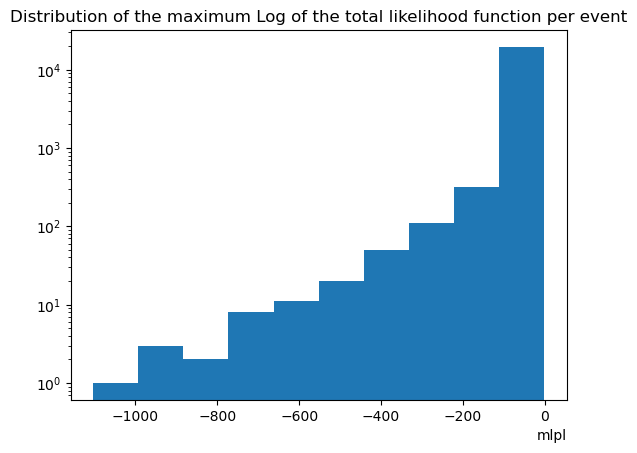

CPU times: user 28min 56s, sys: 18.4 s, total: 29min 14s
Wall time: 29min 14s


In [15]:
%%time
""" Getting the distribution for the dijet sample (mc21_13p6TeV.801167.Py8EG_A14NNPDF23LO_jj_JZ2.recon.AOD.e8453_s3873_r13983) """
dist = get_max_log_likelihood_dist("../user.maboelel.32438279._000005.output.h5", 20000)
plot_distribution(dist)

In [79]:
dist_1 = get_max_log_likelihood_dist("../user.maboelel.32438279._000005.output.h5", 500)

The time of execution of this function is : 52.468586921691895 s


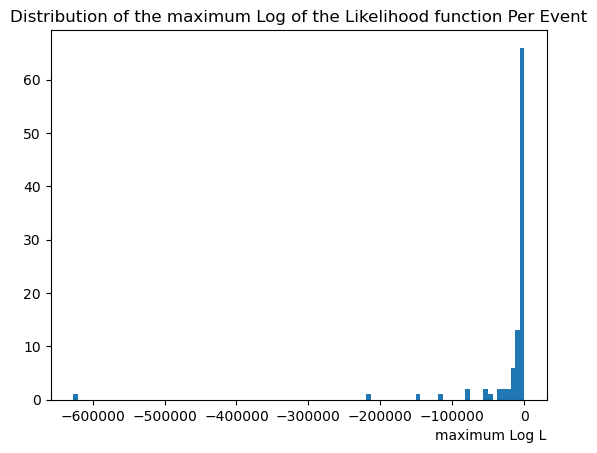

CPU times: user 1min 48s, sys: 264 ms, total: 1min 49s
Wall time: 1min 49s


In [39]:
%%time
""" Getting the distribution for the EB data sample (data22_13p6TeV:data22_13p6TeV.00440499.physics_EnhancedBias.recon.AOD.
r14725_r14726_tid33689943_00) """
dist = get_max_log_likelihood_dist("../data22_13p6TeV.00440499.physics_EnhancedBias.h5")
plot_distribution(dist)

In [20]:
data = File("../data22_13p6TeV.00440499.physics_EnhancedBias.h5", 'r')
jets = data['jets']
uniques = np.unique(jets["eventNumber"])
    
fom_events = []

no_of_processed_events = 100
counter = 0

for id in uniques:
    if len(jets[jets["eventNumber"] == id]) >= 4:
        fom_events.append(id)
        counter +=1
    if counter == no_of_processed_events:
        break
            

In [28]:
len(jets[jets["eventNumber"] == fom_events[1]])

7

In [37]:
max_log_likelihood_list = []

for id in fom_events:        
    max_log_likelihood_list.append(get_max_log_likelihood(id))


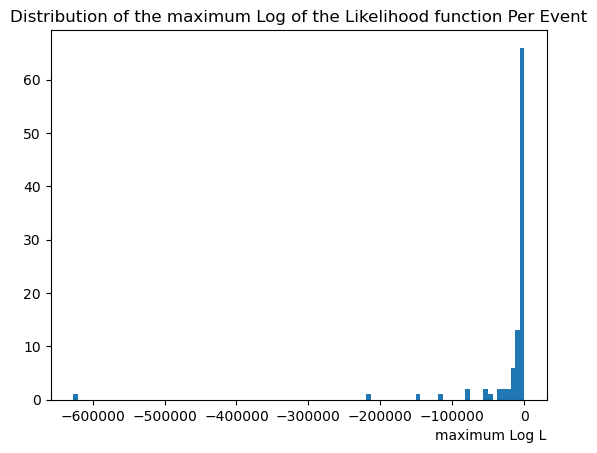

In [38]:
plot_distribution(max_log_likelihood_list)